# Testing Eddy Parameterisation at 0.25°

This notebook outlines a series of experiments to test eddy parameterisations in the eddy-permitting ACCESS-OM2-025.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client

IPython.display.clear_output()

## To deal with memory issues:
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.24:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.0.64.24:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157`
* Then, make sure the following cell matches the scheduler address.

In [2]:
client = Client('tcp://10.0.64.2:8786', local_dir='/local/g40/amh157')
#client = Client()
client

Client Scheduler: tcp://10.0.64.2:8786 Dashboard: http://10.0.64.2:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


## Simulations

We will compare four different simulations, all at 0.25° with KDS50 vertical resolution:
1. **IAF**: Our first IAF attempt, with a full 5 cycles (300 years). This run was infected with horrific Ross Sea polynyas, at the start of every cycle, which overwhelmed the overturning circulation and shut down the AMOC.
2. **GMRedi**: A case with weak Aredi and AGM. Basically, we set Aredi to scale with latitude, with a minimum value of 1m^2/s and a maximum of 200m^2/s. The AGM has the same range and also scales with latitude - but uses the baroclinic closure, so is very weak in unstratified regions (where, for example, polynyas form). This means that AGM is relatively weak in the polar regions (see plot below). This run still had polynyas, but the effect on the AMOC was recued.
3. **No GMRedi6**: Same as the original IAF case, but with a modified surface salt restoring which limit ROss Sea polynya activity. (Still running)
4. **GMRedi6:** Same is GMRedi but with redued salinity restoring.

In [3]:
esub = [
 '025deg_jra55v13_iaf',
 '025deg_jra55v13_iaf_gmredi',
 '025deg_jra55v13_iaf_nogmredi6',
 '025deg_jra55v13_iaf_gmredi6',
       ]

CPU times: user 47.2 s, sys: 17.8 s, total: 1min 5s
Wall time: 1min 50s


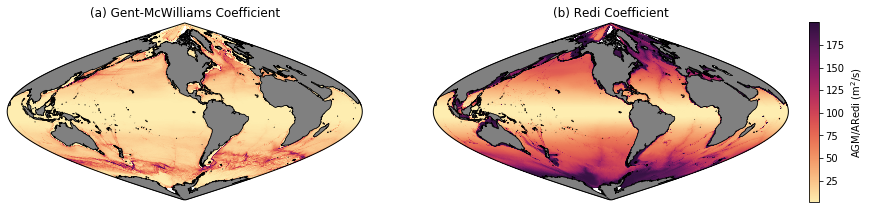

In [4]:
%%time
expt = esub[3]
AGM = cc.get_nc_variable(expt, 'ocean_month.nc', 'agm',n=-10,time_units = None)
ARedi = cc.get_nc_variable(expt, 'ocean_month.nc', 'aredi',n=-10,time_units = None)
IPython.display.clear_output()

plt.figure(figsize=(14,5))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
ax1 = plt.subplot(1,2,1,projection=ccrs.Sinusoidal(central_longitude=-100))
ax1.coastlines(resolution='50m')
ax1.add_feature(land_50m)
p1 = AGM.mean('time').plot(ax=ax1,cmap=cm.cm.matter,add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
ax1.set_title('(a) Gent-McWilliams Coefficient')

ax2 = plt.subplot(1,2,2,projection=ccrs.Sinusoidal(central_longitude=-100))
ax2.coastlines(resolution='50m')
ax2.add_feature(land_50m)
ARedi.mean('time').plot(ax=ax2,cmap=cm.cm.matter,add_colorbar=False,extend='max',transform=ccrs.PlateCarree())
ax2.set_title('(b) Redi Coefficient')


ax4 = plt.axes([0.92,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax4,orientation='vertical')
cb.ax.set_ylabel('AGM/ARedi (m$^2$/s)')

plt.savefig('AGMRedi.png')

**This plot shows** the eddy parameterisation values from the last 20 years of the GMRedi case. Note that ARedi is, in general, larger than AGM, especially in polar regions where weak baroclinicity acts to reduce the AGM parameter. This may not be optimal for the purposes of damping polynya activity??

## Drake Passage Transport

CPU times: user 1min 28s, sys: 36.9 s, total: 2min 5s
Wall time: 6min 43s


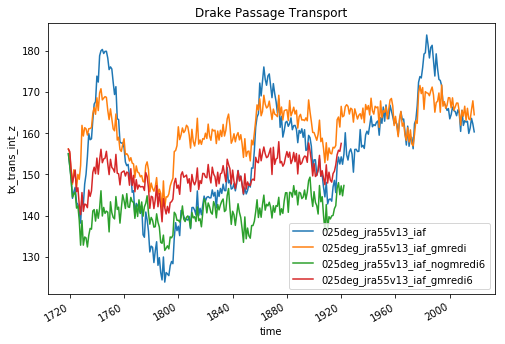

In [4]:
%%time
results=[]
for expt in esub:
    print(expt)
    tx = cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',
                         chunks={'yt_ocean':200},time_units = 'days since 1718-01-01',offset=-87658,
                         use_bag=False)
    
    tx_trans = tx.sel(xu_ocean=-69,method='nearest').sel(yt_ocean=slice(-72,-52))
    
    transport = tx_trans.sum('yt_ocean').resample(time="A").mean('time')*1.0e-9
    result = {'transport': transport,'expt': expt}
    results.append(result)
IPython.display.clear_output()    

plt.figure(figsize=(8,5))
for result in results:
    result['transport'].plot(label=result['expt'])
plt.legend()
plt.title('Drake Passage Transport')
plt.gca().autoscale()


plt.savefig('DPTransport.png')

**The large Drake Passage transport** in IAF cases is possibly related to polynya activity (but it isn't well-correlated in time, see below).

## Other timeseries

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cook

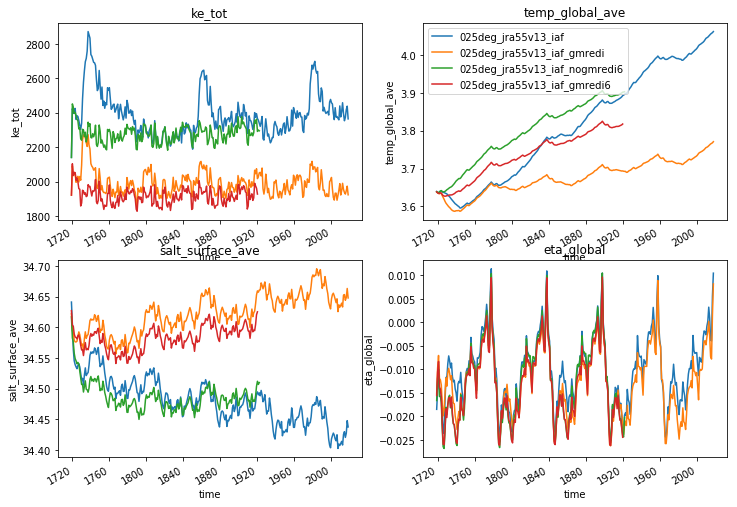

In [5]:
variables = ['ke_tot',
             'temp_global_ave', 
             'salt_surface_ave',
             'eta_global'
            ] ## No more than 4 at a time, please.

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax = [y for x in axes for y in x]  ## flattening the list out.
for ii, var in enumerate(variables):
    for expt in esub:
        darray = cc.get_nc_variable(expt,'ocean_scalar.nc',var,
                         time_units = 'days since 1718-01-01',offset=-87658)
        annual_average = darray.resample(time="A").mean('time')
        annual_average.plot(ax = ax[ii],label=expt)
    ax[ii].set_title(var)

ax[1].legend()

# Mixed Layer Depth


CPU times: user 3min 39s, sys: 38.6 s, total: 4min 18s
Wall time: 6min 46s


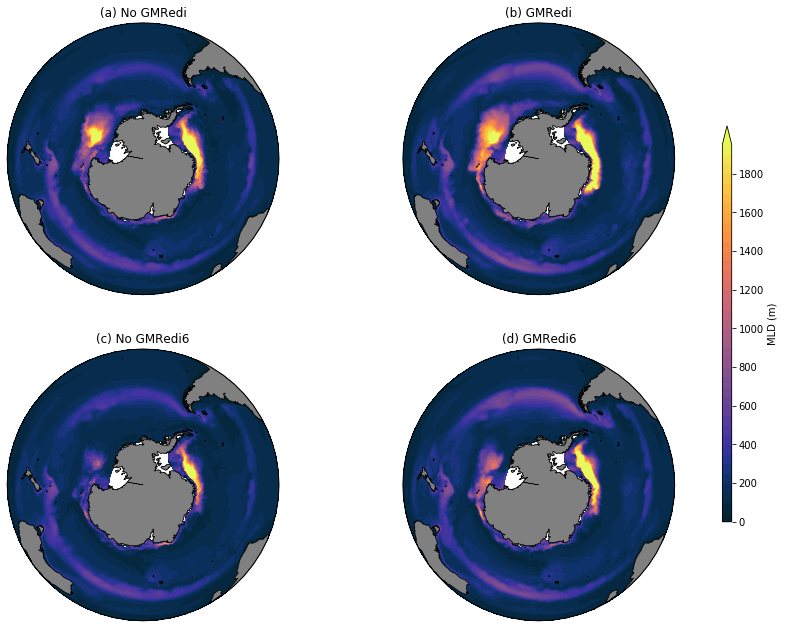

In [11]:
%%time
results=[]
for expt  in esub:
    MLD = cc.get_nc_variable(expt, 'ocean_month.nc', 'mld',time_units = 'days since 1718-01-01',offset=-87658)
    MLD = MLD.groupby('time.month').mean('time').sel(month=8)
    result = {'MLD': MLD,'expt': expt}
    results.append(result)

IPython.display.clear_output()  

plt.figure(figsize=(13,11))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',linewidth=0.5)
clev=np.arange(0,2000,50)

labels=['(a) No GMRedi','(b) GMRedi','(c) No GMRedi6','(d) GMRedi6']
for i,result  in enumerate(results):
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.NearsidePerspective(central_longitude=-100.0, 
                        central_latitude=-90.0, satellite_height=35785831, false_easting=0))
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    p1=result['MLD'].plot.contourf(ax=ax,cmap=cm.cm.thermal,levels=clev,extend='max',add_colorbar=False,transform=ccrs.PlateCarree())
    ax.set_title(labels[i])

ax4 = plt.axes([0.92,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax4,orientation='vertical')
cb.ax.set_ylabel('MLD (m)')

plt.savefig('MLD.png')

**This plot shows** mixed layer depths in August, averaged over the entire run. Large Ross Sea polynyas occur in the IAF case, and they don't really seem to be reduced by the addition of GMRedi.

CPU times: user 1min 40s, sys: 39.4 s, total: 2min 20s
Wall time: 7min 10s


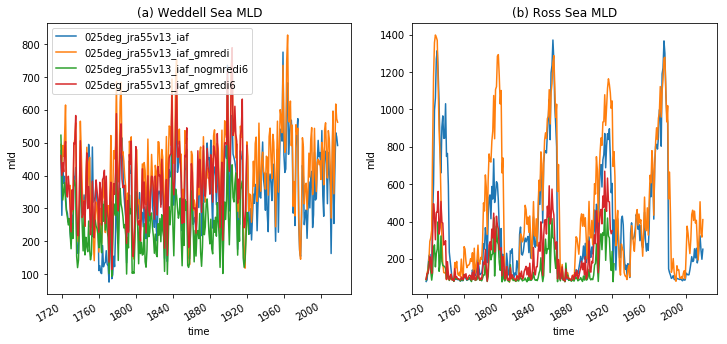

In [6]:
%%time
results=[]
for i,expt  in enumerate(esub):
    MLD = cc.get_nc_variable(expt, 'ocean_month.nc', 'mld',time_units = 'days since 1718-01-01',offset=-87658)
    MLD_wed = MLD.sel(xt_ocean=slice(-50,-10)).sel(yt_ocean=slice(-75,-60))\
                    .mean('xt_ocean').mean('yt_ocean').resample(time='A').mean('time').load()
    MLD_ross = MLD.sel(xt_ocean=slice(-190,-150)).sel(yt_ocean=slice(-75,-60))\
                    .mean('xt_ocean').mean('yt_ocean').resample(time='A').mean('time').load()
    result = {'MLD_wed': MLD_wed,'MLD_ross': MLD_ross,'expt': expt}
    results.append(result)
    
IPython.display.clear_output()  

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for result in results:
    result['MLD_wed'].plot(ax=ax[0],label=result['expt'])
    result['MLD_ross'].plot(ax=ax[1],label=result['expt'])

ax[0].set_title('(a) Weddell Sea MLD')
plt.gca().autoscale()
ax[0].legend()

ax[1].set_title('(b) Ross Sea MLD')
plt.gca().autoscale()

**This plot shows** the time evolution of the Ross Sea polynyas. There is a clear cycle in the IAF cases, synchronous with the IAF cycle, showing that perhaps forcing around 1960 is pretty anomalous. On the other hand, Weddell Sea polynya activity is roughly constant over the duration of the simulation.

## Overturning Circulation

In [7]:
def calc_psi_avg(expt, n=4):
    ## n reads in teh first n files of the timeseries
    
    
    ## Load overturning from ocean.nc file
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=n,
                          time_units=None, offset=None)
    psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        GM = True
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None}, n=n,
                              time_units=None, offset=None)
        psiGM = psiGM.mean('time').sum('grid_xt_ocean')*1.0e-9
    else:
        GM = False
        
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    if GM:
        psi_avg = psi_avg + psiGM
    
    ## This function basically splits the calculation up to save on memory:
    #psi_avg = cc.compute_by_block(psi_avg)
    psi_avg = psi_avg.load()
    
    return psi_avg

In [8]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

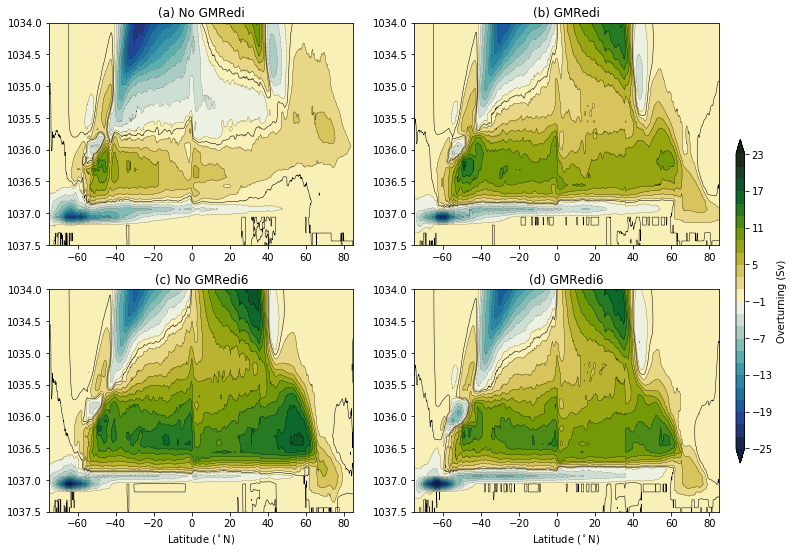

In [9]:
plt.figure(figsize=(12,9))
clev=np.arange(-25,25,2)

n_files = -10

results=[]
for expt in esub:
    psi_avg = calc_psi_avg(expt,n_files)
    result = {'psi_avg':psi_avg,'expt':expt}
    results.append(result)
    
IPython.display.clear_output()  

labels=['(a) No GMRedi','(b) GMRedi','(c) No GMRedi6','(d) GMRedi6']
for i, result in enumerate(results):
    plt.subplot(2,2,i+1)
    p1=plot_psi(result['psi_avg'],clev)
    plt.title(labels[i])
    if i<2:
        plt.xlabel('')
    if np.mod(ii,2)==1:
        plt.ylabel('')

ax4 = plt.axes([0.92,0.2,0.01,0.5])
cb = plt.colorbar(p1,cax=ax4,orientation='vertical')
cb.ax.set_ylabel('Overturning (Sv)')

plt.savefig('overturning.png')

**This plots shows** overturning circulation over the last full cycle of the simulation, noting that the GMRedi cases has had less time to spin up. 

CPU times: user 1min 16s, sys: 36.3 s, total: 1min 52s
Wall time: 14min 30s


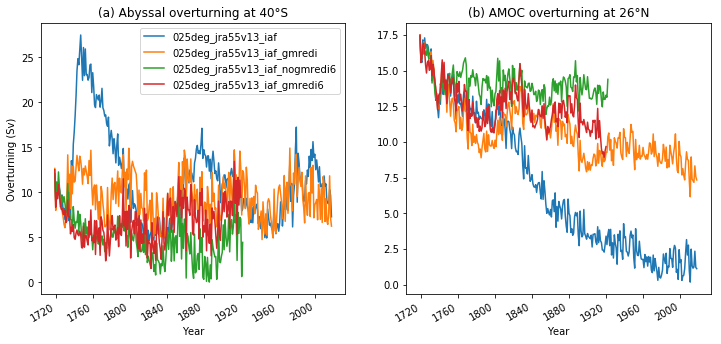

In [10]:
%%time
results=[]
for expt in esub:    
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                            chunks={'potrho': None},
                            time_units='days since 1718-01-01',offset=-87658)
    psi_40S = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
    psi_40S_sum = psi_40S.cumsum('potrho') - psi_40S.sum('potrho')
    
    
    psi_26N = psi.sel(method='Nearest',grid_yu_ocean=26)\
                    .sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean')*1.0e-9
    psi_26N_sum = psi_26N.cumsum('potrho') - psi_26N.sum('potrho')

    psi_aabw = -psi_40S_sum.sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean('time')
    psi_amoc = psi_26N_sum.sel(potrho=slice(1035.5,None))\
                .max('potrho').resample(time='A').mean('time')
    
    result = {'psi_aabw':psi_aabw,'psi_amoc':psi_amoc,'expt':expt}
    results.append(result)
    
IPython.display.clear_output()  

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i,result in enumerate(results):
    result['psi_aabw'].plot(ax=ax[0],label=result['expt'])
    result['psi_amoc'].plot(ax=ax[1],label=result['expt'])
    

ax[0].legend()
ax[0].set_ylabel('Overturning (Sv)')
ax[0].set_xlabel('Year')
ax[0].set_title('(a) Abyssal overturning at 40°S')
plt.gca().autoscale()

ax[1].set_xlabel('Year')
ax[1].set_ylabel('')
ax[1].set_title('(b) AMOC overturning at 26°N')
plt.gca().autoscale()

plt.savefig('overturning_timeseries.png')

**This plot shows** the global abyssal overturning and the Atlantic overturning at 26N. Note that the large abyssal overturning in the IAF case (polynya-driven) is weaker with GMRedi (even though polynyas are still present). The timescale of complete collapse of the AMOC in the IAF case is several IAF cycles. It's not yet clear if the same will occur with GMRedi.

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


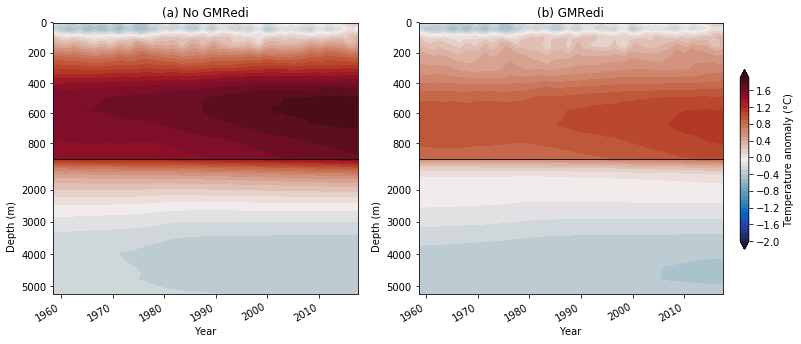

In [4]:
# Heat Uptake
fig,ax = plt.subplots(2,2,sharex=True,figsize=(12,5))
plt.subplots_adjust(hspace=0)
levs = np.arange(-2,2,0.1)

temp_WOA13 = cc.get_nc_variable('woa13/025_KDS50', 'woa13_ts_??_mom025.nc', 'temp').mean('time').compute()
for i, expt in enumerate(esub[:2]):
    temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp',n=-30,
                    time_units='days since 1718-01-01',offset=-87658)
    temp_anom = temp - temp_WOA13.values - 273.15

    area_t = cc.get_nc_variable(expt,'ocean_grid.nc','area_t',n=1)
    mask = temp.isel(time=0).copy()
    mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
    area = mask*area_t
    area_sum = area.sum('xt_ocean').sum('yt_ocean')

    var =area_t*temp_anom
    temp_hov = var.sum('xt_ocean').sum('yt_ocean').load()
    temp_hov = temp_hov/area_sum
    
    t_up = temp_hov.sel(st_ocean=slice(0,1000))
    t_lo = temp_hov.sel(st_ocean=slice(1000,6000))

    axx=ax[0,i]
    t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False,extend='both')
    axx.set_ylabel('')
    axx=ax[1,i]
    p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False,extend='both')
    axx.set_ylabel('Depth (m)')
    axx.set_xlabel('Year')

ax[0,0].set_title('(a) No GMRedi')

ax[0,1].set_title('(b) GMRedi')


ax4 = plt.axes([0.92,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax4,orientation='vertical')
cb.ax.set_ylabel('Temperature anomaly (°C)')

plt.savefig('heat_uptake.png')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


KeyboardInterrupt: 

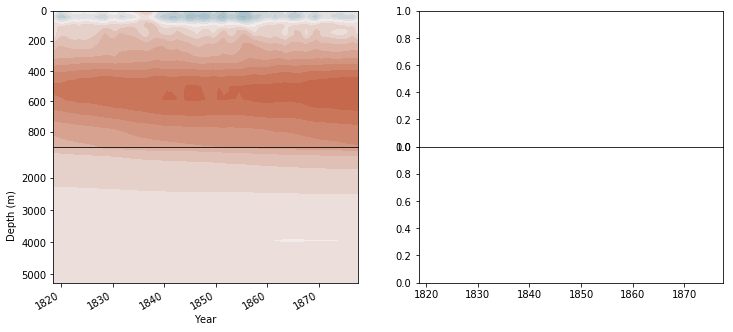

In [9]:
# HEat Uptake 2
fig,ax = plt.subplots(2,2,sharex=True,figsize=(12,5))
plt.subplots_adjust(hspace=0)
levs = np.arange(-2,2,0.1)

temp_WOA13 = cc.get_nc_variable('woa13/025_KDS50', 'woa13_ts_??_mom025.nc', 'temp').mean('time').compute()
for i, expt in enumerate(esub[2:4]):
    temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp',n=-30,
                    time_units='days since 1718-01-01',offset=-87658)
    temp_anom = temp - temp_WOA13.values - 273.15

    area_t = cc.get_nc_variable(expt,'ocean_grid.nc','area_t',n=1)
    mask = temp.isel(time=0).copy()
    mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
    area = mask*area_t
    area_sum = area.sum('xt_ocean').sum('yt_ocean')

    var =area_t*temp_anom
    temp_hov = var.sum('xt_ocean').sum('yt_ocean').load()
    temp_hov = temp_hov/area_sum
    
    t_up = temp_hov.sel(st_ocean=slice(0,1000))
    t_lo = temp_hov.sel(st_ocean=slice(1000,6000))

    axx=ax[0,i]
    t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False,extend='both')
    axx.set_ylabel('')
    axx=ax[1,i]
    p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False,extend='both')
    axx.set_ylabel('Depth (m)')
    axx.set_xlabel('Year')

ax[0,0].set_title('(a) No GMRedi')

ax[0,1].set_title('(b) GMRedi')


ax4 = plt.axes([0.92,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax4,orientation='vertical')
cb.ax.set_ylabel('Temperature anomaly (°C)')

plt.savefig('heat_uptake2.png')

## Conclusions

* Polynyas, particularly in the Ross Sea, are problematic in the IAF simulation, driving a very strong abyssal cell.
* There is a collapse in the AMOC which takes ~100 years to manifest, and which may be due to the influence of the strong abyssal overturning.
* The weak GMRedi used here didn't really help to remove the polynyas, but *does* slow down the abyssal cell. It's not yet clear how the AMOC will respond.

## Next Steps
1. Try stronger GM in polar gyres?? (started, 10 years in...)
2. Eliminate first decade from IAF??